### Importing all the necessary libraries:

In [62]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import scipy.stats as stats
import pymysql
import getpass

from sqlalchemy import create_engine
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn import datasets

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#password = getpass.getpass()

### Connecting and importing the data set from MySQL, also using pandas:

In [4]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_regression'
engine = create_engine(connection_string)
query = '''
        SELECT *
        FROM house_price_regression.house_price_data;
        '''

In [6]:
housing_data_sql = pd.read_sql_query(query, engine)
housing_data_sql.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [17]:
engine_view = create_engine(connection_string)
query_view = '''
        SELECT *
        FROM Houses_with_higher_than_double_average_price
        ORDER BY price DESC;
        '''

In [18]:
housing_data_sqlview = pd.read_sql_query(query_view, engine_view)
housing_data_sqlview.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,6762700020,6,8.00,12050,27600,3,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,7700000
1,9808700762,5,4.50,10040,37325,2,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,7060000
2,9208900037,6,7.75,9890,31374,2,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,6890000
3,2470100110,5,5.75,9200,35069,2,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,5570000
4,8907500070,5,5.00,8000,23985,2,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,5350000


#### Remarks: the last one here is extracting it directly from a created view for the regularly interested findings on the list of properties whose prices are twice more than the average of all the properties.

In [63]:
# read the data and store data in DataFrame titled housing_data
housing_data = pd.read_csv('/Users/spicasumampouw/IronSpica/project/Mid-bootcamp-project/mid-bootcamp-project/regression/data/regression_data.csv') 

# print a overview of the data in Housing data
housing_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


### Data Cleaning & EDA

In [64]:
# review the list of all columns in the dataset
housing_data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

#### Remarks: the columns is already standarized, so no need to do anything here

In [65]:
# setting id as an index because it is the id and unique
housing_data.set_index('id',inplace = True)
#housing_data.columns = [column.lower().replace(' ', '_') for column in df.columns]

In [66]:
# count the values in the data
housing_data.value_counts().count()

21597

In [67]:
# check null values in the data
#housing_data.isna().sum()
housing_data.isnull().values.sum()

0

In [68]:
# reviewing data types
#housing_data.info()
housing_data.dtypes

date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [69]:
# rounding the number to read easier and print a summary of the data in Housing data
housing_data.describe().apply(lambda x: round(x,2))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,3.37,2.12,2080.32,15099.41,1.49,0.01,0.23,3.41,7.66,1788.60,291.73,1971.00,84.46,98077.95,47.56,-122.21,1986.62,12758.28,540296.57
std,0.93,0.77,918.11,41412.64,0.54,0.09,0.77,0.65,1.17,827.76,442.67,29.38,401.82,53.51,0.14,0.14,685.23,27274.44,367368.14
min,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,78000.00
25%,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00,322000.00
50%,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00,450000.00
75%,4.00,2.50,2550.00,10685.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00,645000.00
max,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00,7700000.00


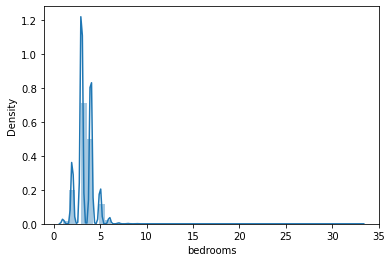

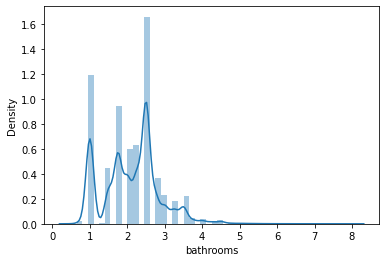

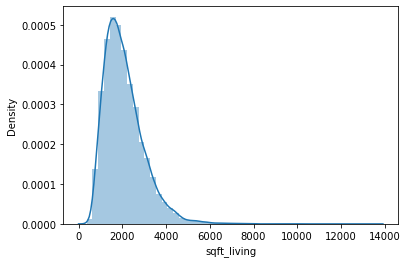

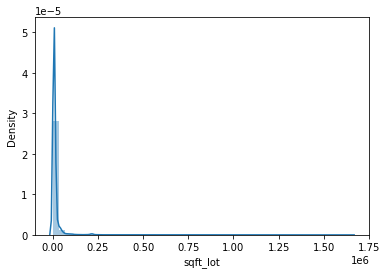

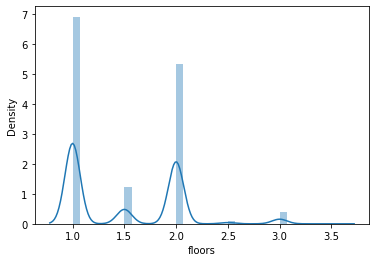

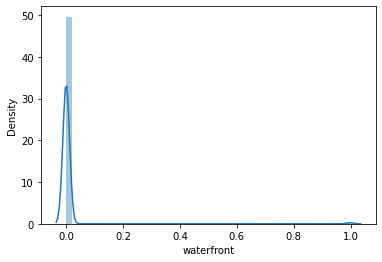

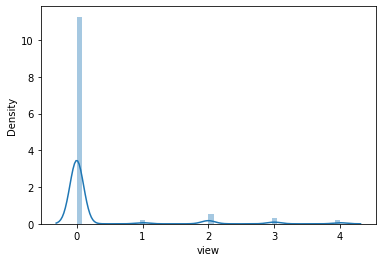

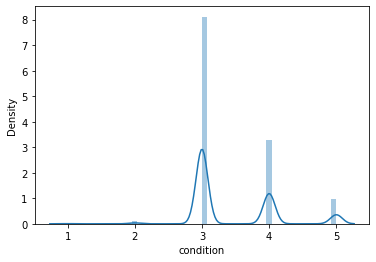

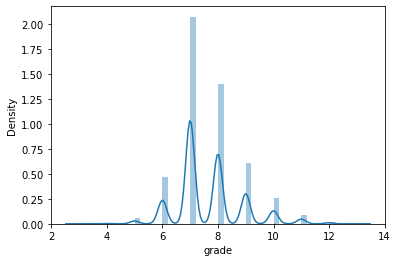

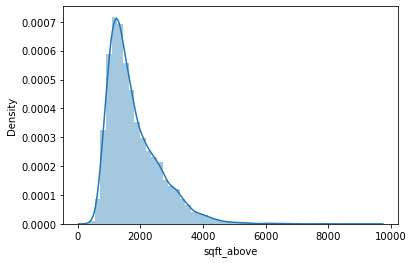

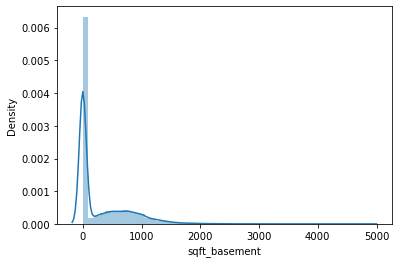

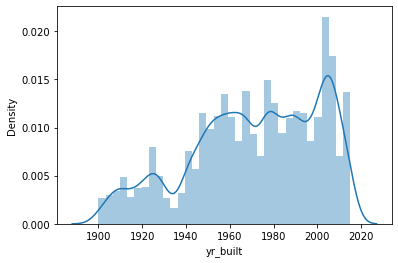

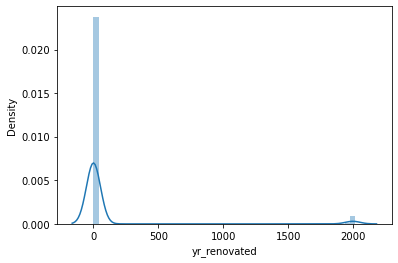

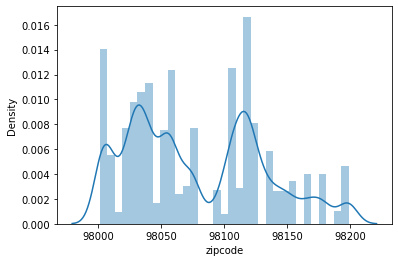

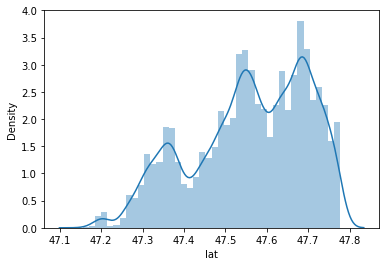

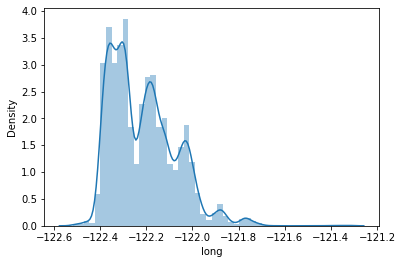

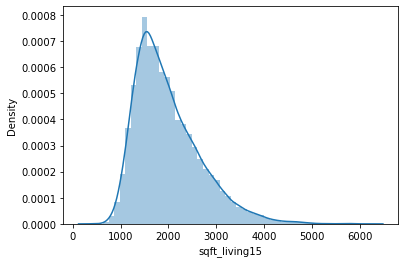

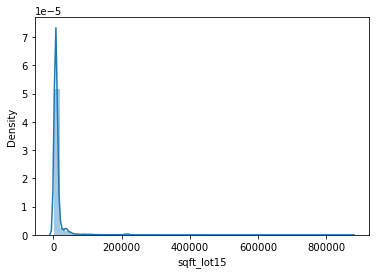

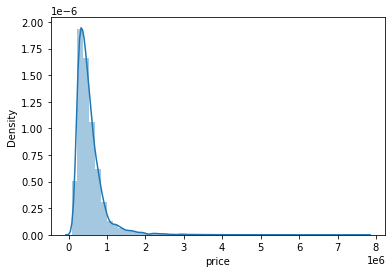

In [70]:
for column in housing_data.select_dtypes(np.number).columns:
    sns.distplot(housing_data[column])
    plt.show()

In [71]:
#X = housing_data.drop(['price', 'date'], axis=1)

# Selecting The Prediction Target
y = housing_data['price']

# Selecting The Features
housing_features = ['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'grade']
X = housing_data[housing_features]

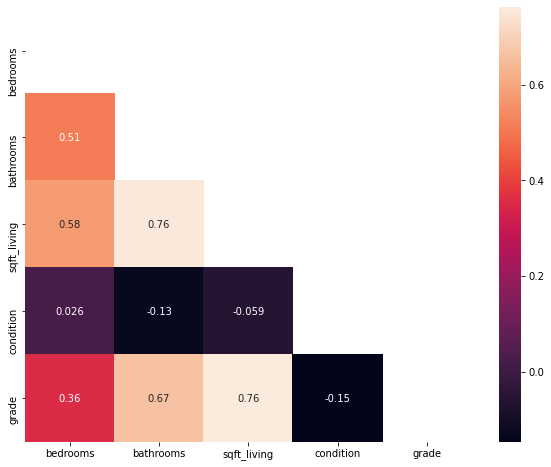

In [72]:
# check the correlations
mask = np.zeros_like(X.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(X.corr(), mask=mask, annot=True)
plt.show()

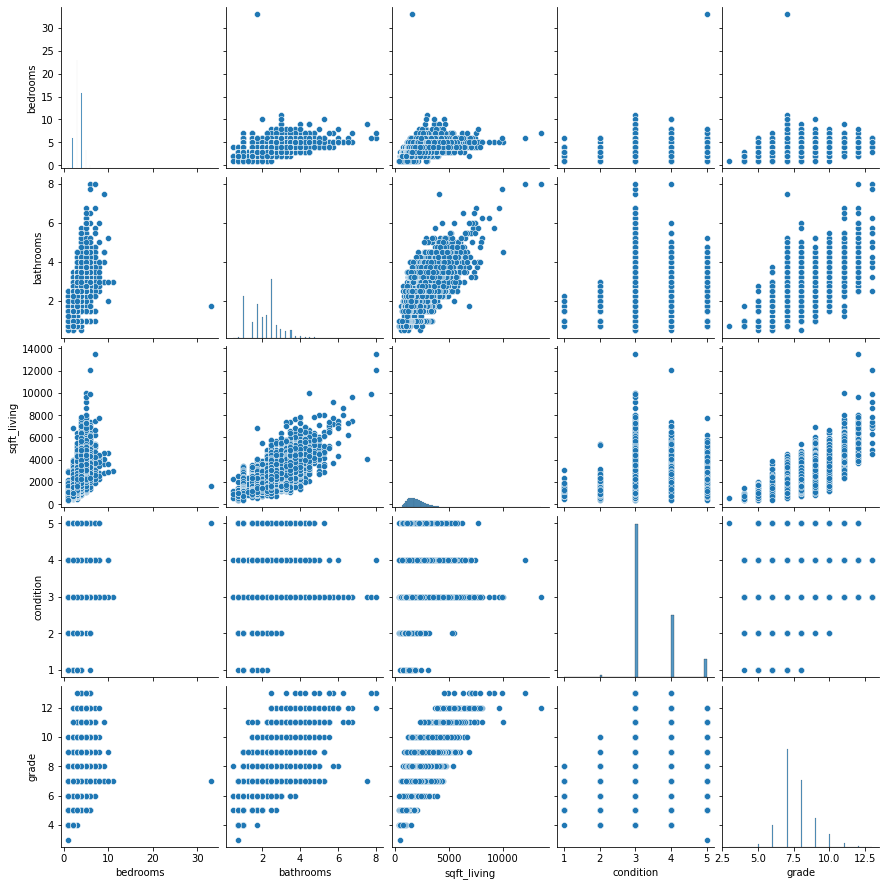

In [73]:
# covariance visualization
sns.pairplot(X)

In [74]:
# sklearn's LR model
lm = LinearRegression() # start the model object
model = lm.fit(X,y) # fit your regression line / train the model
# lm.coef_ # lm.intercept_

In [75]:
# evaluating sklearn's LR model
predictions = lm.predict(X) # predict some values
rmse = mean_squared_error(y, predictions, squared=False) # or mse with squared=True
# r2 is the overall estimate of how good the model is, between 0 (lowest) and 1 (highest)
# rmse, is to see if the errors are big, the values returnes are in the unit of the target
print("R2_score:", round(lm.score(X,y),2)) # or r2_score(Y, predictions)
print("RMSE:", rmse)

R2_score: 0.56
RMSE: 244683.78240993724


<AxesSubplot:xlabel='grade', ylabel='price'>

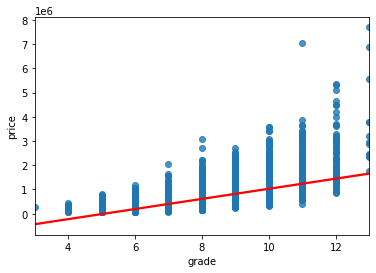

In [76]:
sns.regplot(X['grade'], y, line_kws={"color": "red"})

<AxesSubplot:xlabel='price'>

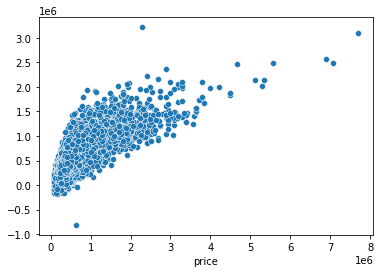

In [77]:
sns.scatterplot(y,predictions)

<AxesSubplot:xlabel='price', ylabel='price'>

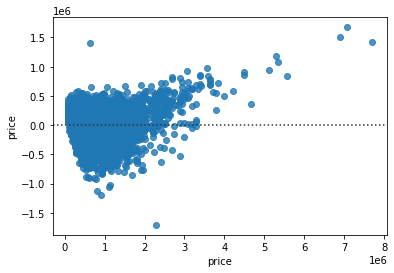

In [78]:
residuals = y - predictions
sns.residplot(y,residuals)

In [79]:
X_train = housing_data[housing_features]
y_train = housing_data['price']

In [80]:
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train);

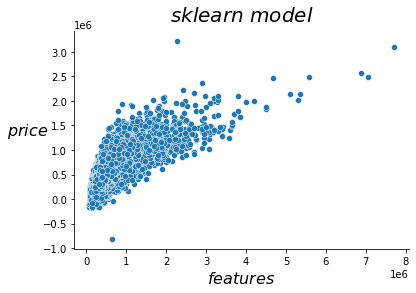

In [86]:
sklearn_predictions = sklearn_model.predict(X_train)
fig, ax = plt.subplots()
sns.scatterplot(y_train, sklearn_predictions)
ax.set_xlabel(r'$features$', size = 16)
ax.set_ylabel(r'$price$', rotation = 0, size = 16, labelpad = 15)
ax.set_title(r'$sklearn$ $model$', size = 20, pad = 10)
sns.despine()

In [87]:
# Implement the model to have an intercept
X = sm.add_constant(X)

model = sm.OLS(y,X).fit() # to train the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     5415.
Date:                Thu, 02 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:16:29   Log-Likelihood:            -2.9861e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21591   BIC:                         5.973e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.466e+05   1.82e+04    -41.022      

In [88]:
# Define model. Specify a number for random_state to ensure same results each run
housing_model = DecisionTreeRegressor(random_state=1)

# Fit model
housing_model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [89]:
# make predictions for the first few rows of the training data
print("Making predictions for the following 5 houses: \n")
print(X.head())
print("\n The price predictions are")
print(housing_model.predict(X.head()))

Making predictions for the following 5 houses: 

            const  bedrooms  bathrooms  sqft_living  condition  grade
id                                                                   
7129300520    1.0         3       1.00         1180          3      7
6414100192    1.0         3       2.25         2570          3      7
5631500400    1.0         2       1.00          770          3      6
2487200875    1.0         4       3.00         1960          5      7
1954400510    1.0         3       2.00         1680          3      8

 The price predictions are
[348237.5        538000.         257453.57142857 604000.
 510000.        ]


In [90]:
# Define model
housing_model = DecisionTreeRegressor()
# Fit model
housing_model.fit(X, y)

DecisionTreeRegressor()

In [91]:
# calculate the mean absolute error:
predicted_home_prices = housing_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

53120.978989352305

In [92]:
# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
# Define model
housing_model = DecisionTreeRegressor()
# Fit model
housing_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = housing_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

185045.81383739616


#### Remarks: the mean absolute error for the in-sample data was about 53000 dollars. Out-of-sample it is more than 185,000 dollars.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [94]:
predictions = model.predict(X_test)

In [95]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.5652425745410787, 156847.26744814176, 237734.46660843873)

In [96]:
# a function to help compare MAE scores from different values for max_leaf_nodes:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [97]:
# compare MAE with differing values of max_leaf_nodes by using a for-loop to compare the accuracy of models built with different values for max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d \t Mean Absolute Error: %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5 	 Mean Absolute Error: 167848
Max leaf nodes: 50 	 Mean Absolute Error: 149096
Max leaf nodes: 500 	 Mean Absolute Error: 153594
Max leaf nodes: 5000 	 Mean Absolute Error: 179279


#### Remarks: of the options listed, 500 is the optimal number of leaves.

In [98]:
# RandomForestRegressor
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
hous_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, hous_preds))

155286.66797502438


In [99]:
# Select target
y = housing_data.price

# To keep things simple, we'll use only numerical predictors
hous_predictors = housing_data.drop(['price'], axis=1)
X = hous_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [100]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [101]:
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE using imputation approach:")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE using imputation approach:
70322.2363957231


### Reviewing data with differents approaches & model

In [103]:
# Read the data
housing_data = pd.read_csv('/Users/spicasumampouw/IronSpica/project/Mid-bootcamp-project/mid-bootcamp-project/regression/data/regression_data.csv')

# Separate target from predictors
y = housing_data.price
X = housing_data.drop(['price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [105]:
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

transformer = Normalizer().fit(X_num)
x_normalized = transformer.transform(X_num)
print(x_normalized.shape)

(21597, 19)


In [106]:
x_normalized

array([[ 1.00000000e+00,  4.20798645e-10,  1.40266215e-10, ...,
        -1.71485267e-08,  1.87956728e-07,  7.92504115e-07],
       [ 1.00000000e+00,  4.67719541e-10,  3.50789656e-10, ...,
        -1.90703289e-08,  2.63482008e-07,  1.19096986e-06],
       [ 1.00000000e+00,  3.55145140e-10,  1.77572570e-10, ...,
        -2.17052280e-08,  4.82997391e-07,  1.43159006e-06],
       ...,
       [ 9.99999998e-01,  1.31293889e-09,  4.92352084e-10, ...,
        -8.02855566e-08,  6.69598834e-07,  1.31753418e-06],
       [ 9.99999943e-01,  1.02983035e-08,  8.58191960e-09, ...,
        -4.19034538e-07,  4.84020266e-06,  4.41797221e-06],
       [ 9.99999998e-01,  1.31293888e-09,  4.92352078e-10, ...,
        -8.02855558e-08,  6.69598827e-07,  8.90829027e-07]])

In [107]:
cat_data = pd.get_dummies(X_cat, drop_first=True)
#cat_data[:5]

In [108]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

In [109]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE using One-Hot Encoding approach:") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE using One-Hot Encoding approach:
70805.78408862434


In [110]:
# Selecting The Prediction Target
y = housing_data['price']

# Selecting The Features
housing_features = ['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'grade']
X = housing_data[housing_features]

In [111]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [112]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [113]:
predictions  = model.predict(X_test)
predictions.shape

(6480,)

In [114]:
# using non-normalized and one-hot encoded data
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(0.5472119719823738, 245028.56548462136, 60038997903.45138)

In [115]:
# using normalized and one-hot encoded data
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(0.5472119719823738, 245028.56548462136, 60038997903.45138)

In [116]:
# using non-normalized and label encoded data
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(0.5472119719823738, 245028.56548462136, 60038997903.45138)

In [117]:
# using normalized and label encoded data
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(0.5472119719823738, 245028.56548462136, 60038997903.45138)

In [118]:
mse = mean_squared_error(y_test, predictions)
print(mse)

60038997903.45138


In [119]:
rmse = math.sqrt(mse)
print(rmse)

245028.56548462136


In [120]:
r2 = r2_score(y_test, predictions)
print(r2)

0.5472119719823738


In [121]:
n = len(X_test)
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
print(adj_r2)

0.5468622747101947


In [122]:
# Read the data
housing_data = pd.read_csv('/Users/spicasumampouw/IronSpica/project/Mid-bootcamp-project/mid-bootcamp-project/regression/data/regression_data.csv')

# Separate target from predictors
y = housing_data.price
X = housing_data.drop(['price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [123]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [124]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [125]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 67064.93985465719


In [126]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

In [127]:
X.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Build and optimize models with gradient boosting, this method that goes through cycles to iteratively add models into an ensemble

In [128]:
# Read the data
housing_data = pd.read_csv('/Users/spicasumampouw/IronSpica/project/Mid-bootcamp-project/mid-bootcamp-project/regression/data/regression_data.csv')

# Selecting The Prediction Target
y = housing_data.price

cols_to_use = ['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'grade', 'zipcode']
X = housing_data[cols_to_use]

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [129]:
my_model = XGBRegressor()
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [130]:
predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 85799.97382378472


In [131]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Remarks: In conclusion, we can create several models using different approaches, but to build an adequate machine learning model that can predict the selling prices of houses is using gradient boosting because it is the most accurate modeling technique for structured data. The model begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

##### This is how the cycle works:
##### First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
##### These predictions are used to calculate a loss function (like mean squared error, for instance).
##### Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
##### Finally, we add the new model to ensemble, and ...
##### ... repeat!